In [1]:
import numpy as np
import pandas as pd
import os
import imutils
import dlib
import cv2
import imageio
from imutils import face_utils
from skimage.transform import resize
import time
import tensorflow as tf
from sklearn.utils import shuffle

2023-10-30 18:55:00.303694: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 18:55:00.565200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 18:55:00.565226: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 18:55:00.566458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 18:55:00.674027: I tensorflow/core/platform/cpu_feature_g

In [2]:
SLASH_TYPE = "/"
BASE_DIR = "." + SLASH_TYPE

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], enable=True)
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
gpus

[]

In [4]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
    	coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords


In [5]:
def crop_and_save_image(img, img_path, write_img_path, img_name):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(BASE_DIR + 'shape_predictor_68_face_landmarks.dat')
    # load the input image, resize it, and convert it to grayscale

    image = cv2.imread(img_path)
    image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    if len(rects) > 1:
    	print( "ERROR: more than one face detected")
    	return
    if len(rects) < 1:
    	print( "ERROR: no faces detected")
    	return
    # print("RECTS", rects)
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        name, i, j = 'mouth', 48, 68
        # clone = gray.copy()

        (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))        
        roi = gray[y:y+h, x:x+w]
        roi = imutils.resize(roi, width = 250, inter=cv2.INTER_CUBIC)        
        #print('cropped/' + write_img_path)
        cv2.imwrite('cropped/' + write_img_path, roi)

In [6]:
# people = ['F01']
# data_types = ['words']
# folder_enum = ['01']
# instances = ['01']

In [18]:

people = ['F01', 'F02', 'F04', 'F05', 'F06', 'F07', 'F08']
data_types = ['words']
folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

In [8]:
# people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
# data_types = ['words']
# folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
# instances = ['01','02','03','04','05','06','07','08', '09', '10']

In [73]:
words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']          
words_di = {i:words[i] for i in range(len(words))}

In [10]:
def crop_one_person():      
    if not os.path.exists('cropped'):
        os.mkdir('cropped')
    # people = ['F01']
    # data_types = ['words']
    # folder_enum = ['01']
    # instances = ['01']

    i = 1
    for person_ID in people:
        if not os.path.exists('cropped/' + person_ID ):
            os.mkdir('cropped/' + person_ID + '/')

        for data_type in data_types:
            if not os.path.exists('cropped/' + person_ID + '/' + data_type):
                os.mkdir('cropped/' + person_ID + '/' + data_type)

            for phrase_ID in folder_enum:
                if not os.path.exists('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID):
                    # F01/phrases/01
                    os.mkdir('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID)

                for instance_ID in instances:
                    # F01/phrases/01/01
                    directory = BASE_DIR + 'dataset/' + person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID + '/'
                    dir_temp = person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID + '/'
                    print(directory)
                    filelist = os.listdir(directory)
                    if not os.path.exists('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID):
                        os.mkdir('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID)

                        for img_name in filelist:
                            if img_name.startswith('color'):
                                image = imageio.imread(directory + '' + img_name)
                                crop_and_save_image(image, directory + '' + img_name,
                                                    dir_temp + '' + img_name, img_name)

    print(f'Iteration : {i}')
    i += 1

In [11]:
# import time

# total_it = 1

# times = 0
# for _ in range(total_it):
#     t1 = time.time()
#     crop_one_person()
#     t2 = time.time()
#     times += (t2 - t1)

# print(f"Average time over {total_it} iterations : ", times/total_it)

In [24]:
max_seq_length = 22

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []


MAX_WIDTH = 100
MAX_HEIGHT = 100

In [ ]:
t1 = time.time()
# UNSEEN_VALIDATION_SPLIT = ['F07', 'M02']
# UNSEEN_TEST_SPLIT = ['F04']
UNSEEN_VALIDATION_SPLIT = ['F07']
UNSEEN_TEST_SPLIT = ['F08']


directory = BASE_DIR + "cropped"

for person_id in people:
    tx1 = time.time()
    for data_type in data_types:
        for word_index, word in enumerate(folder_enum):
#             print(f"Word : '{words[word_index]}'")
            for iteration in instances:
                path = os.path.join(directory, person_id, data_type, word, iteration)
                filelist = sorted(os.listdir(path + SLASH_TYPE))
                sequence = [] 
                for img_name in filelist:
                    if img_name.startswith('color'):
                        image = imageio.imread(path + SLASH_TYPE + img_name)
                        image = resize(image, (MAX_WIDTH, MAX_HEIGHT))
                        image = 255 * image
                        # Convert to integer data type pixels.
                        image = image.astype(np.uint8)
                        sequence.append(image)                        
                pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))]                            
                sequence.extend(pad_array * (max_seq_length - len(sequence)))
                sequence = np.array(sequence)
                if person_id in UNSEEN_TEST_SPLIT:
                    X_test.append(sequence)
                    y_test.append(word_index)
                elif person_id in UNSEEN_VALIDATION_SPLIT:
                    X_val.append(sequence)
                    y_val.append(word_index)
                else:
                    X_train.append(sequence)
                    y_train.append(word_index)    
    tx2 = time.time()
    print(f'Finished reading images for person {person_id}. Time taken : {tx2 - tx1} secs.')
    
t2 = time.time()
print(f"Time taken for creating constant size 3D Tensors from those cropped lip regions : {t2 - t1} secs.")

In [14]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(500, 22, 100, 100)
(100, 22, 100, 100)
(100, 22, 100, 100)


In [15]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(500,)
(100,)
(100,)


In [29]:
def normalize_it(X):
    v_min = X.min(axis=(2, 3), keepdims=True)
    v_max = X.max(axis=(2, 3), keepdims=True)
    X = (X - v_min)/(v_max - v_min)
    X = np.nan_to_num(X)
    return X

In [ ]:
X_train = normalize_it(X_train)
X_val = normalize_it(X_val)
X_test = normalize_it(X_test)

In [ ]:
train_val_test = np.array([X_train, X_val, X_test, y_train, y_val, y_test])
with open("train_val_test.npy", "wb") as f:
    np.save(f, train_val_test)

In [5]:
with open("train_val_test.npy", "rb") as f:
    train_val_test = np.load(f, allow_pickle=True)

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test

In [7]:
from keras import backend

In [8]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

In [9]:
X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(700, 22, 100, 100, 1)
(100, 22, 100, 100, 1)
(100, 22, 100, 100, 1)


In [17]:
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
from keras.utils import plot_model
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

In [18]:
model = Sequential()

# 1st layer group
model.add(Conv3D(64, (3, 3, 3), strides = 1, input_shape=(22, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(256, (2, 2, 2), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add((Flatten()))

# # FC layers group
model.add(Dense(4096, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 98, 98, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 49, 49, 64)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 47, 47, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 4, 23, 23, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 22, 22, 256)    262400    
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 1, 11, 11, 256)    0

2023-10-30 19:14:48.815459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 19:14:48.846309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 19:14:48.846343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 19:14:48.848610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-30 19:14:48.848646: I tensorflow/compile

In [20]:
tf.device('/gpu:0')
checkpoint_path = BASE_DIR + "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [17]:
with tf.device('/gpu:0'):
    t1 = time.time()
    # EARLY STOPPING
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=4, callbacks=[cp_callback])
    t2 = time.time()
    print()
    print(f"Training time : {t2 - t1} secs.")

Epoch 1/40


2023-10-30 15:54:57.363491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-30 15:54:57.865371: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-30 15:54:58.618597: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-30 15:54:59.466367: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f23d2bfef10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 15:54:59.466409: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-10-30 15:54:59.472024: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 15:54:59.550080: I ./tensorflow/compiler/jit/

175/175 [==============================] - ETA: 0s - loss: 2.3058 - accuracy: 0.0786
Epoch 1: saving model to ./checkpoints/cp.ckpt
175/175 [==============================] - 19s 90ms/step - loss: 2.3058 - accuracy: 0.0786 - val_loss: 2.3010 - val_accuracy: 0.1300
Epoch 2/40
175/175 [==============================] - ETA: 0s - loss: 2.2972 - accuracy: 0.0971
Epoch 2: saving model to ./checkpoints/cp.ckpt
175/175 [==============================] - 15s 83ms/step - loss: 2.2972 - accuracy: 0.0971 - val_loss: 2.2979 - val_accuracy: 0.1100
Epoch 3/40
175/175 [==============================] - ETA: 0s - loss: 2.2868 - accuracy: 0.1586
Epoch 3: saving model to ./checkpoints/cp.ckpt
175/175 [==============================] - 15s 83ms/step - loss: 2.2868 - accuracy: 0.1586 - val_loss: 2.2937 - val_accuracy: 0.1200
Epoch 4/40
175/175 [==============================] - ETA: 0s - loss: 2.2781 - accuracy: 0.1500
Epoch 4: saving model to ./checkpoints/cp.ckpt
175/175 [==============================]

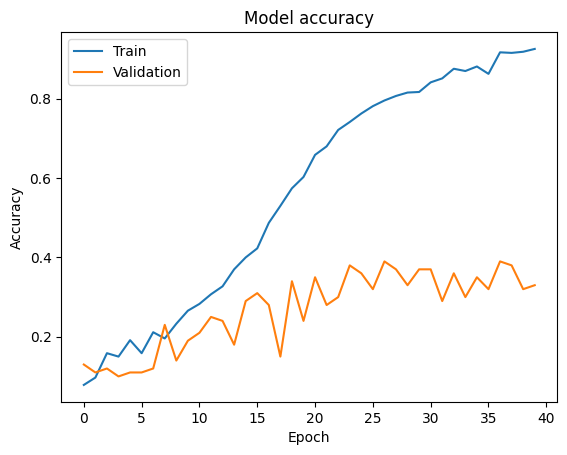

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model.load_weights(checkpoint_path)

In [ ]:
ypred = model.predict(X_test, batch_size=4)

In [19]:
predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test, axis=1)] 

In [20]:
correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
    print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print(f"Accuracy = {accuracy} on completely unseen data")

Predicted : Connection 	 Actual : Connection
Predicted : Hello 	 Actual : Hello
Predicted : Hello 	 Actual : Begin
Predicted : Previous 	 Actual : Previous
Predicted : Choose 	 Actual : Stop
Predicted : Web 	 Actual : Web
Predicted : Choose 	 Actual : Choose
Predicted : Stop 	 Actual : Stop
Predicted : Hello 	 Actual : Previous
Predicted : Start 	 Actual : Web
Predicted : Hello 	 Actual : Previous
Predicted : Start 	 Actual : Web
Predicted : Stop 	 Actual : Stop
Predicted : Choose 	 Actual : Choose
Predicted : Hello 	 Actual : Begin
Predicted : Hello 	 Actual : Navigation
Predicted : Connection 	 Actual : Connection
Predicted : Choose 	 Actual : Connection
Predicted : Start 	 Actual : Navigation
Predicted : Previous 	 Actual : Begin
Predicted : Start 	 Actual : Next
Predicted : Start 	 Actual : Start
Predicted : Hello 	 Actual : Begin
Predicted : Choose 	 Actual : Stop
Predicted : Hello 	 Actual : Next
Predicted : Hello 	 Actual : Next
Predicted : Hello 	 Actual : Begin
Predicted : Web

In [13]:
capture = cv2.VideoCapture(BASE_DIR+"test_video/video.mp4")

frame_n = 0

while True:
    success, frame = capture.read()

    if success:
        cv2.imwrite(f"{BASE_DIR}test_video/frames/{frame_n}.jpg", frame)
    else:
        break

    frame_n += 1

capture.release()
print(frame_n)

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


In [15]:

for frame_i in range(frame_n):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(BASE_DIR + 'shape_predictor_68_face_landmarks.dat')
    # load the input image, resize it, and convert it to grayscale

    image = cv2.imread(f'{BASE_DIR}test_video/frames/{frame_i}.jpg')
    image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    if len(rects) > 1:
        print( "ERROR: more than one face detected")
    elif len(rects) < 1:
        print( "ERROR: no faces detected")
    else:
        # print("RECTS", rects)
        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            name, i, j = 'mouth', 48, 68
            # clone = gray.copy()

            (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))        
            roi = gray[y:y+h, x:x+w]
            roi = imutils.resize(roi, width = 250, inter=cv2.INTER_CUBIC)        
            #print('cropped/' + write_img_path)
            cv2.imwrite(f'{BASE_DIR}test_video/cropped/{frame_i}.jpg', roi)

In [96]:
sequence = []
for frame_i in range(frame_n):
    image = imageio.imread(f'{BASE_DIR}test_video/cropped/{frame_i}.jpg')
    image = resize(image, (MAX_WIDTH, MAX_HEIGHT))
    image = 255 * image
    # Convert to integer data type pixels.
    image = image.astype(np.uint8)
    sequence.append(image)     


/tmp/ipykernel_677/4275746742.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f'{BASE_DIR}test_video/cropped/{frame_i}.jpg')


In [97]:
sequence = np.array(sequence)
sequence = np.pad(sequence, [(0, 2), (0, 0), (0, 0)], mode='constant')
sequence.shape

(22, 100, 100)

In [98]:
v_min = sequence.min(axis=2, keepdims=True)
v_max = sequence.max(axis=2, keepdims=True)
sequence = (sequence - v_min)/(v_max - v_min)
sequence = np.nan_to_num(sequence)
sequence = np.expand_dims(sequence, axis=(0,4))
sequence.shape

/tmp/ipykernel_677/3096950758.py:3: RuntimeWarning: invalid value encountered in divide
  sequence = (sequence - v_min)/(v_max - v_min)


(1, 22, 100, 100, 1)

In [99]:
pred = model.predict(sequence)

1/1 [==============================] - 0s 431ms/step


In [101]:
print(words[np.argmax(pred)])

Choose
